# Hubble Ultra Deep Field (f105w)

### reusing the sep workflow on the udf f105w image and then grabbing basic flux stats and a fake 3 color image towards the end

In [76]:
import numpy as np
import sep
import math
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Ellipse


sep.set_extract_pixstack(1000000)     # allow more active pixels
sep.set_sub_object_limit(100000)      # allow more sub-objects when deblending

%matplotlib inline
rcParams["figure.figsize"] = [10., 8.]



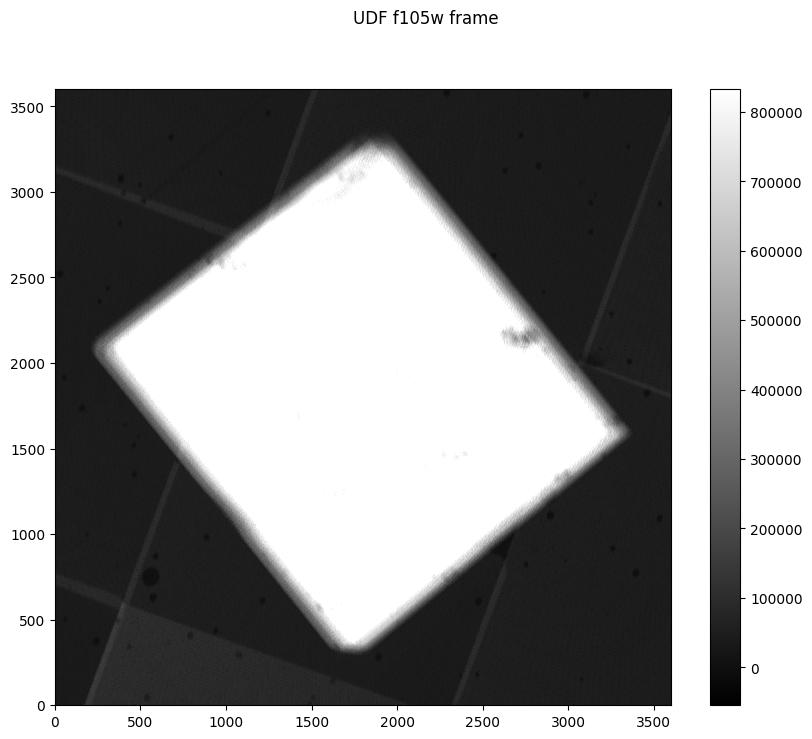

In [77]:
path = "../data/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_wht.fits"

img = fits.getdata(path)
img = img.astype(img.dtype.newbyteorder('='))

mid, spread = np.mean(img), np.std(img)

fig, ax = plt.subplots()
show = ax.imshow(
    img,
    interpolation = "nearest",
    cmap = "gray",
    vmin = mid - spread,
    vmax = mid + spread,
    origin = "lower",
)

fig.colorbar(show,ax=ax)
fig.suptitle("UDF f105w frame")
fig.savefig("../figs/udf105_img.png", dpi=150, bbox_inches="tight")
plt.show()


In [78]:
backg = sep.Background(img)
img_sub = img - backg

print("f105w backg level:", backg.globalback)
print("f105w backg rms:", backg.globalrms)

f105w backg level: 51645.92578125
f105w backg rms: 5524.89013671875


In [79]:
sources105 = sep.extract(img_sub, 3, err=backg.globalrms)
len(sources105)

6014

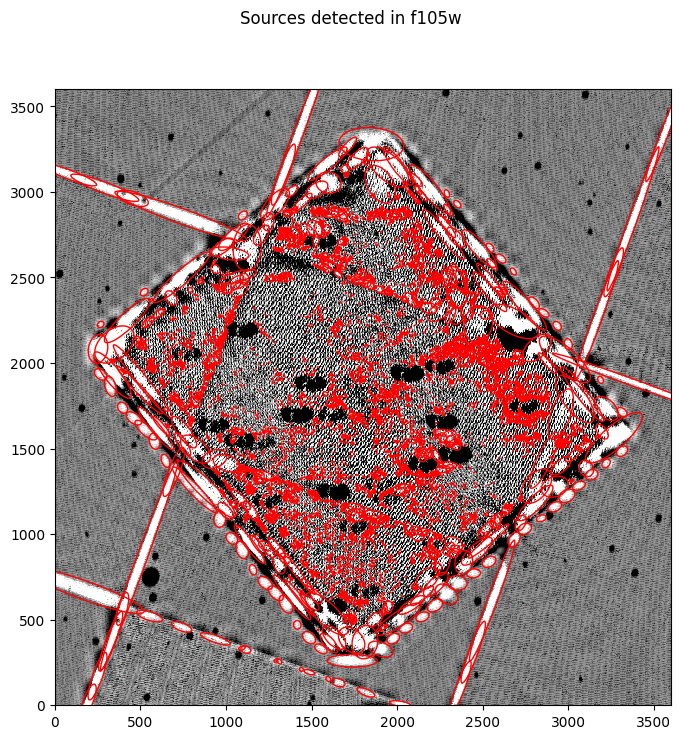

In [80]:
fig, ax = plt.subplots()
midimg_sub, spreadimgsub = np.mean(img_sub), np.std(img_sub)

show = ax.imshow(
    img_sub,
    interpolation = "nearest",
    cmap = "gray",
    vmin = midimg_sub - spreadimgsub,
    vmax = midimg_sub + spreadimgsub,
    origin = "lower",
)

for i in range(len(sources105)):
    e = Ellipse(
        xy=(sources105["x"][i], sources105["y"][i]),
        width=6 * sources105["a"][i],
        height=6 * sources105["b"][i],
        angle=sources105["theta"][i] * 180.0 / math.pi,
    )
    e.set_facecolor("none")
    e.set_edgecolor("red")
    ax.add_artist(e)

fig.suptitle("Sources detected in f105w")
fig.savefig("../figs/udf105_sources.png", dpi=150, bbox_inches="tight")
plt.show()

In [81]:

# looks like way too much???

# this frame appears to be EXTREMELY crowded, so SEP is detecting a large number of sources

In [82]:
fluximg, fluxerr_img, img_flag = sep.sum_circle(
    img_sub,
    sources105["x"],
    sources105["y"],
    3.0,
    err=backg.globalrms,
    gain = 1.0,
)

len(fluximg)

6014

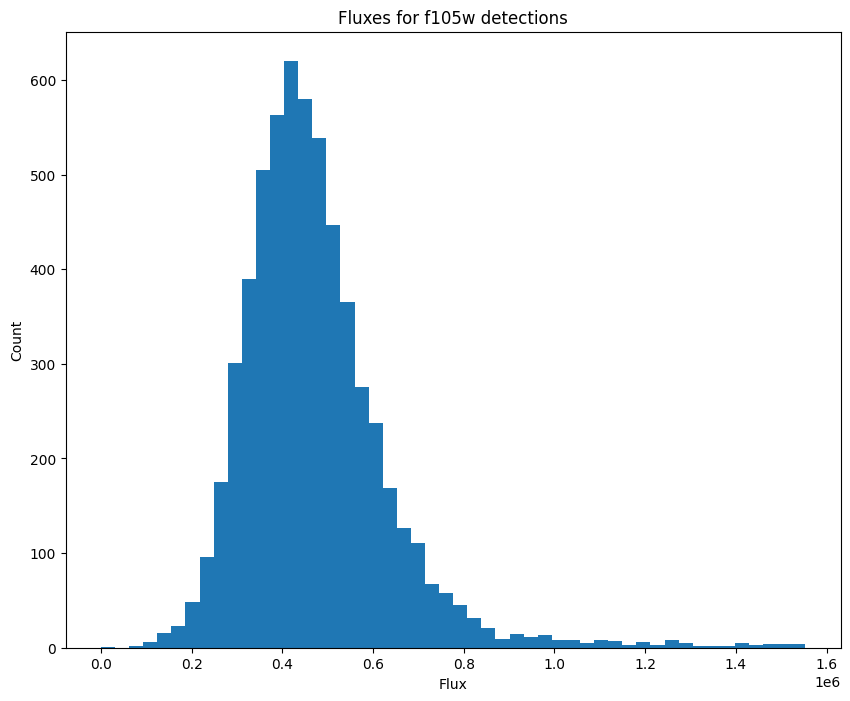

In [83]:
fig, ax = plt.subplots()

ax.hist(
    fluximg,
    bins=50,
    range = (0, np.percentile(fluximg, 99))
)

ax.set_xlabel("Flux")
ax.set_ylabel("Count")
ax.set_title("Fluxes for f105w detections")
fig.savefig("../figs/udf105_fux_hist.png", dpi=150, bbox_inches="tight")
plt.show()

# This shows the distribution of the aperture fluexes for all the sources SEP found. I trimmed it to just the top 1% so it's easier to see, if I make it much more inclusive it starts to lose its distinction.

In [84]:
flux_mean = np.mean(fluximg)
flux_med = np.median(fluximg)
flux_std = np.std(fluximg)

flux_mean, flux_med, flux_std

(np.float64(493744.8979306359),
 np.float64(447949.58125000005),
 np.float64(297503.6189097662))

In [85]:
bright_idx = np.argmax(fluximg)
bright_flux = fluximg[bright_idx]
bright_x = sources105["x"][bright_idx]
bright_y = sources105["y"][bright_idx]

bright_sigma = (bright_flux - flux_mean) / flux_std #sigma67
bright_flux, bright_x, bright_y, bright_sigma 

(np.float64(6689740.9750000015),
 np.float64(2680.484120481588),
 np.float64(2242.1778018842438),
 np.float64(20.826624226539682))

# From the flux histogram, pretty much every source is very faint. The brightest source I found has a flux of about 6.7 x 10^6 counts and it is found at x = 2680, y = 2240 or so which is 21 standard deviations above the mean. It's way out of the tail of the distribution so it's a very strong outlier. 

In [92]:
path125 = "../data/hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits" #shouldve done my naming of the original one better to keep it consistent but u get the idea
path160 = "../data/hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits"

img125 = fits.getdata(path125)
img160 = fits.getdata(path160)

img125 = img125.astype(img125.dtype.newbyteorder("="))
img160 = img160.astype(img160.dtype.newbyteorder("="))

back125 = sep.Background(img125)
back160 = sep.Background(img160)

img160_sub = img160 - back160
img125_sub = img125 - back125 # i was testing scaling the color channels because blue was dominating but im just gonna leave it in incase it comes up again


In [96]:
r = img160 - np.min(img160)
r = r / np.max(r)

g = img125 - np.min(img125)
g = g / np.max(g)

b = img - np.min(img)
b = b / np.max(b)

rgb = np.dstack([r, g, b])

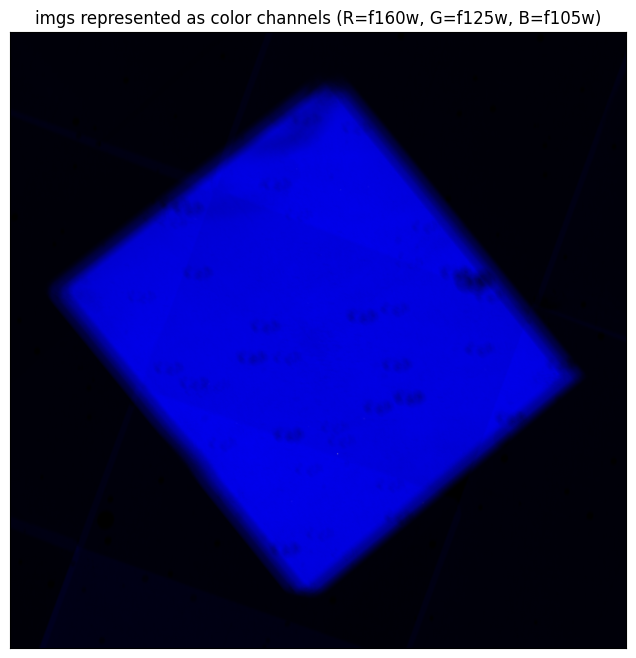

In [97]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(rgb, origin="lower")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("imgs represented as color channels (R=f160w, G=f125w, B=f105w)")
fig.savefig("../figs/udf_rgb.png", dpi=200, bbox_inches="tight")
plt.show()


# I'm not quite sure how to interpret the output. It's coming out very blue whereas I feel as if it would be a little more balanced. However, everything looks right to me and it just may be that 105w is the dominating channel in this instance.